<a href="https://colab.research.google.com/github/Mehreen66/MachineLearning/blob/main/CEEMDAN-S-C-LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas numpy PyEMD scipy tensorflow keras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.6/662.6 kB 3.0 MB/s eta 0:00:00


Epoch 1/100
73/73 [==============================] - 6s 26ms/step - loss: 0.0387
Epoch 2/100
73/73 [==============================] - 2s 29ms/step - loss: 4.8900e-04
Epoch 3/100
73/73 [==============================] - 3s 41ms/step - loss: 3.5896e-04
Epoch 4/100
73/73 [==============================] - 2s 28ms/step - loss: 3.3614e-04
Epoch 5/100
73/73 [==============================] - 2s 25ms/step - loss: 3.2851e-04
Epoch 6/100
73/73 [==============================] - 2s 25ms/step - loss: 3.2504e-04
Epoch 7/100
73/73 [==============================] - 2s 25ms/step - loss: 3.1650e-04
Epoch 8/100
73/73 [==============================] - 2s 25ms/step - loss: 2.9948e-04
Epoch 9/100
73/73 [==============================] - 3s 35ms/step - loss: 3.0170e-04
Epoch 10/100
73/73 [==============================] - 3s 38ms/step - loss: 2.7982e-04
Epoch 11/100
73/73 [==============================] - 2s 26ms/step - loss: 2.7663e-04
Epoch 12/100
73/73 [==============================] - 2s 26ms/step 

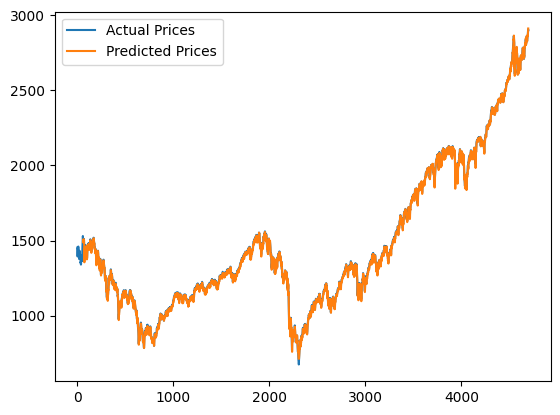

In [4]:
!pip install EMD-signal

import pandas as pd
import numpy as np
from PyEMD import CEEMDAN
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense, Flatten
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('sp500.csv')
prices = df['Close'].values

# Data preprocessing
ceemdan = CEEMDAN()
imfs = ceemdan.ceemdan(prices)

# Filter noise using Savitzky-Golay filter
filtered_imfs = [savgol_filter(imf, window_length=5, polyorder=3) for imf in imfs]
filtered_data = np.sum(filtered_imfs, axis=0)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(filtered_data.reshape(-1, 1))

# Prepare dataset for training
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X, y = create_dataset(normalized_data, time_step)

# Reshape input to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Build the model
model = Sequential()
model.add(Conv1D(filters=3, kernel_size=3, activation='relu', input_shape=(time_step, 1)))
model.add(Conv1D(filters=3, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=3, kernel_size=3, activation='relu'))
model.add(LSTM(24, return_sequences=False))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=64, verbose=1)

# Make predictions
train_predict = model.predict(X)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
actual_prices = scaler.inverse_transform(normalized_data)

# Plotting
plt.plot(actual_prices, label='Actual Prices')
plt.plot(np.arange(time_step, time_step + len(train_predict)), train_predict, label='Predicted Prices')
plt.legend()
plt.show()

